In [1]:
import os 
import pandas as pd 
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms,models,utils
from tqdm.notebook import tqdm
# from tqdm import tqdm_notebook as tqdm
from torch import nn
import matplotlib.pyplot as plt
import torch.optim as optim
# from torch.utils.tensorboard import SummaryWriter 
# from torchvision import datasets, transforms,utils
from random import sample

In [14]:
train_path='./train'
valid_path='./train'
test_path='./test'
model_path='./cat_vs_dog_model.pt'

In [3]:
def give_label(img):
    if img.split('.')[0]=='dog':
        return 1
    else:
        return 0
#数据集类的创建
class MyDataset(Dataset):
    def __init__(self,data_path,mode='train',valid_ratio=0.2) -> None:
        """
        data_path:数据集存放的目录
        mode：判断此时是那个模式

        """
        super().__init__()

        self.data_path=data_path
        self.mode=mode
        #获取文件夹中的图片名称
        self.img_list=os.listdir(data_path)
        self.img_list_len=len(self.img_list)

        #注意这里一定要加上int转换数据类型 不然是浮点类型的话无法取样
        self.train_img=sample(self.img_list,int((1-valid_ratio)*self.img_list_len))
        self.valid_img=list(set(self.img_list).difference(set(self.train_img)))

        #初始化img_arr 其中存放的是图片名称
        if mode=='train':
            self.img_arr=self.train_img
        elif mode=='valid':
            self.img_arr=self.valid_img
        else:
            self.img_arr=self.img_list

        self.real_len=len(self.img_arr)

    def __getitem__(self, index):
        img_name=self.img_arr[index]
        img_as_img=Image.open(self.data_path+'/'+img_name)

        #若是训练模式则需要给图片打标签 狗为1，猫为0
        if self.mode=='train':
            label=give_label(img_name)
            transform=transforms.Compose([
                transforms.Resize(size=(224,224)),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.ToTensor()
            ])
        elif self.mode=='valid':
            label=give_label(img_name)
            #验证集和测试集不需要对图片进行数据增强
            transform=transforms.Compose([
                transforms.Resize(size=(224,224)),
                transforms.ToTensor()
            ])
        else:
            #测试集的图片是数字.jpg 
            label=int(img_name.split('.')[0])
            transform=transforms.Compose([
                transforms.Resize(size=(224,224)),
                transforms.ToTensor()
            ])
        
        # 必须使用long 类型数据，否则后面训练会报错 expect long
        label=torch.as_tensor(label,dtype=torch.int64)
        img_as_img=transform(img_as_img)

        if self.mode=='test':
            return img_as_img
        else:
            return img_as_img,label
    
    def __len__(self):
        return self.real_len

In [4]:
train_data=MyDataset(data_path=train_path,mode='train')
valid_data=MyDataset(data_path=valid_path,mode='valid')
test_data=MyDataset(data_path=test_path,mode='test')

In [5]:
for i, item in enumerate(tqdm(train_data)):
#     pass
    print(item[0].shape)
    break

  0%|          | 0/20000 [00:00<?, ?it/s]

torch.Size([3, 224, 224])


In [6]:
train_loader=torch.utils.data.DataLoader(train_data,batch_size=64,shuffle=True,num_workers=0)
valid_loader=torch.utils.data.DataLoader(valid_data,batch_size=64,shuffle=True,num_workers=0)
test_loader=torch.utils.data.DataLoader(test_data,batch_size=64,shuffle=True,num_workers=0)

In [7]:
#经过加载的数据形状从三维变成了4维，多出来的是批量
for i,item in enumerate(train_loader):
    print(item[0].shape)
    break

torch.Size([64, 3, 224, 224])


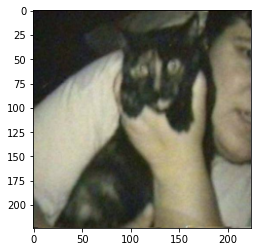

In [8]:
#查看resize后的图像
img_PIL_Tensor=train_data[0][0]
new_img_PIL=transforms.ToPILImage()(img_PIL_Tensor).convert('RGB')
plt.imshow(new_img_PIL)
plt.show()

In [9]:
#开始构建网络咯 这里是自己定义的网络 当然也可以用库里已经预训练过的网络
import torch.nn.functional as F

class MyCNN(nn.Module):
    def __init__(self):
        super().__init__()
        #这个卷积层过后，通道增加，图片大小不变
        self.conv1=nn.Conv2d(3,8,kernel_size=7,stride=1,padding=3)
        #池化后尺寸减半
        self.pool=nn.MaxPool2d(kernel_size=2,stride=2)
        #尺寸不变
        self.conv2=nn.Conv2d(8,16,kernel_size=3,stride=1,padding=1)       
        #
        self.fc1=nn.Linear(16*56*56,256)
        self.fc2=nn.Linear(256,64)
        self.fc3=nn.Linear(64,2)
    
    def forward(self,X):
        X=self.pool(F.relu(self.conv1(X)))
        X=self.pool(F.relu(self.conv2(X)))

        #将数据平整为1维的
        X=X.view(-1,16*56*56)
        X=F.relu(self.fc1(X))
        X=F.relu(self.fc2(X))
        X=self.fc3(X)

        return X

In [10]:
#损失函数和优化函数
net=MyCNN()
criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(net.parameters(),lr=0.001,momentum=0.9)

In [11]:
#训练日志的打印

class AvgrateMeter(object):
    def __init__(self) -> None:
        self.resnet()
    
    def resnet(self):
        self.avg=0
        self.sum=0
        self.cnt=0
    
    def update(self,val,n=1):
        self.sum +=val*n
        self.cnt +=n
        self.avg=self.sum/self.cnt

In [13]:
#topk的准确率计算
def accuracy(output,label,topk=(1,)):
    maxk=max(topk)
    batch_size=label.size(0)

    _,pred=output.topk(maxk,1,True,True)#使用topk来获得前k个的索引
    pred=pred.t()#进行转置

    correct=pred.eq(label.view(1,-1).expand_as(pred))

    rtn=[]
    for k in topk:
        # 前k行的数据 然后平整到1维度，来计算true的总个数
        correct_k=correct[:k].view(-1).float().sum(0)
        rtn.append(correct_k.mul(100.0/batch_size))
    
    return rtn

In [ ]:
#定义训练咯
def train(model,train_loader,criterion,optimizer,epoch,device):
    model=model.to(device)
    
    for e in range(epoch):
        model.train()
        train_loss=[]
        train_acc=[]

        for batch in tqdm(train_loader):
            imgs,labels=batch
            imgs=imgs.to(device)
            labels=labels.to(device)

            logits=model(imgs)
            loss=criterion(logits,labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            acc=(logits.argmax(dim=-1)==labels).float().mean()

            train_loss=train_loss.append(loss)
            train_acc=train_acc.append(acc)
        
        train_loss=sum(train_loss)/len(train_loss)
        train_acc=sum(train_acc)/len(train_acc)

        print(f'训练周期：{e+1:03d}/{epoch:03d} 训练损失：{train_loss:.5f} 训练精度：{train_acc:.5f}')

#定义验证咯

        model=model.to(device)
        model.eval()

        best_acc=0.0
        valid_loss=[]
        valid_acc=[]

        for batch in tqdm(valid_loader):
            imgs,labels=batch

            imgs=imgs.to(device)
            labels=labels.to(device)

            with torch.no_grad():
                logits=model(imgs)

            loss=criterion(logits,labels)

            acc=(logits.argmax(-1)==labels).float().mean()

            valid_loss=valid_loss.append(loss)
            valid_acc=valid_acc.append(acc)

        valid_loss=sum(valid_loss)/len(valid_loss)
        valid_acc=sum(valid_acc)/len(valid_acc)

        print(f'验证周期：{e+1:03d}/{epoch:03d} 验证损失：{valid_loss:.5f} 验证精度：{valid_acc:.5f}')

            #对最佳验证精度做一个记载
        if valid_acc >best_acc:
            best_acc=valid_acc
            torch.save(model.state_dict(),model_path)
            print('正在保存精度为{:.3f}的模型'.format(best_acc))  


In [ ]:
def submission(csv_path,test_loader,device,model):
    result_list=[]
    model=model.to(device)
    with torch.no_grad():
        for i,data in enumerate(test_loader,0):
            imgs,labels=data[0].to(device),data[1].to(device)
            logits=model(imgs)
            softmax_func=nn.Softmax(dim=1)
            soft_output=softmax_func(logits)
            predicted=soft_output[:,1]

            for i in range(len(predicted)):
                result_list.append({
                    'id':labels[i].item(),
                    'label':predicted[i].item()
                })
            
    columns=result_list[0].keys()
    result_dict={col:[anno[col] for anno in result_list] for col in columns }
    result_df=pd.DataFrame(result_dict)
    result_df=result_df.sort_values('id')
    result_df.to_csv(csv_path,index=None)
    